In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [89]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

In [90]:
DATA_PATH = r"E:\Python\Machile Learning\3_Machile Learning\Research\NextEnergy\XAI-ML-SOC-Prediction-TimeSeries\Dataset\Lithium-Ion Battery Drive Cycle Dataset\2_preprocessed"

In [91]:
def load_drive_cycle_data(base_path=DATA_PATH):
    """
    Load drive cycle CSVs into a nested dictionary: {temperature: {drive_cycle_name: DataFrame}}
    """
    data_dict = {}
    for folder in sorted(os.listdir(base_path)):
        if "JY_SOC_" not in folder:
            continue
        try:
            temp = int(folder.replace("JY_SOC_", "").replace("deg", ""))
        except ValueError:
            continue
        folder_path = os.path.join(base_path, folder)
        data_dict[temp] = {}
        for file in sorted(os.listdir(folder_path)):
            if file.endswith(".csv"):
                drive_name = file.replace(".csv", "")
                file_path = os.path.join(folder_path, file)
                df = pd.read_csv(file_path)
                data_dict[temp][drive_name] = df
    return data_dict

In [92]:
drive_data = load_drive_cycle_data()

In [93]:
print("Available temperatures:", drive_data.keys())
print("Example cycles at 5°C:", list(drive_data[15].keys()))

Available temperatures: dict_keys([15, 25, 35, 45, 5])
Example cycles at 5°C: ['10_PDTCB_15deg', '11_PDMHC_15deg', '12_OCTBC_15deg', '1_BCDC_15deg', '2_LA92_15deg', '3_HHDDT_15deg', '4_CSHVC_15deg', '5_FTP-72_15deg', '6_FTP-75_15deg', '7_HWFET_15deg', '8_IM_15deg', '9_US06_15deg']


In [94]:
temperatures = [5, 15, 25, 35, 45]

data = {}
load_count = 0

# Loop through each temperature folder
for temp in temperatures:
    folder_name = f"JY_SOC_{temp}deg"
    folder_path = os.path.join(DATA_PATH, folder_name)

    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        continue

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)

            try:
                df = pd.read_csv(file_path)

                # Extract cycle name from filename
                # Format: <number>_<cycle_name>_<temp>deg.csv
                parts = file_name.split("_")
                cycle_name = "_".join(parts[1:-1])  # skip index and temperature

                # Store in dictionary using (temp, cycle_name) as key
                data[(temp, cycle_name)] = df
                load_count += 1

                print(f"Loaded: {file_name}")
            except Exception as e:
                print(f"Failed to load {file_path}: {e}")

print(f"\n✅ Total CSV files loaded: {load_count}")

Loaded: 10_PDTCB_5deg.csv
Loaded: 11_PDMHC_5deg.csv
Loaded: 12_OCTBC_5deg.csv
Loaded: 1_BCDC_5deg.csv
Loaded: 2_LA92_5deg.csv
Loaded: 3_HHDDT_5deg.csv
Loaded: 4_CSHVC_5deg.csv
Loaded: 5_FTP-72_5deg.csv
Loaded: 6_FTP-75_5deg.csv
Loaded: 7_HWFET_5deg.csv
Loaded: 8_IM_5deg.csv
Loaded: 9_US06_5deg.csv
Loaded: 10_PDTCB_15deg.csv
Loaded: 11_PDMHC_15deg.csv
Loaded: 12_OCTBC_15deg.csv
Loaded: 1_BCDC_15deg.csv
Loaded: 2_LA92_15deg.csv
Loaded: 3_HHDDT_15deg.csv
Loaded: 4_CSHVC_15deg.csv
Loaded: 5_FTP-72_15deg.csv
Loaded: 6_FTP-75_15deg.csv
Loaded: 7_HWFET_15deg.csv
Loaded: 8_IM_15deg.csv
Loaded: 9_US06_15deg.csv
Loaded: 10_PDTCB_25deg.csv
Loaded: 11_PDMHC_25deg.csv
Loaded: 12_OCTBC_25deg.csv
Loaded: 1_BCDC_25deg.csv
Loaded: 2_LA92_25deg.csv
Loaded: 3_HHDDT_25deg.csv
Loaded: 4_CSHVC_25deg.csv
Loaded: 5_FTP-72_25deg.csv
Loaded: 6_FTP-75_25deg.csv
Loaded: 7_HWFET_25deg.csv
Loaded: 8_IM_25deg.csv
Loaded: 9_US06_25deg.csv
Loaded: 10_PDTCB_35deg.csv
Loaded: 11_PDMHC_35deg.csv
Loaded: 12_OCTBC_35deg.cs

In [95]:
"""
all data cycle

['PDTCB', 'PDMHC', 'OCTBC', 'BCDC', 'LA92', 'HHDDT', 'CSHVC', 'FTP-72', 'FTP-75', 'HWFET', 'IM', 'US06']

"""

df = data[(25, 'FTP-72')]
print(df.head())


   Time   Voltage       Current  Temperature  SOC
0   0.0  4.179963 -1.468638e-06     25.55283  1.0
1   0.1  4.180153 -5.573469e-07     25.55283  1.0
2   0.2  4.180153 -2.382668e-07     25.55283  1.0
3   0.3  4.180153 -7.958415e-08     25.55283  1.0
4   0.4  4.180153 -3.974810e-08     25.55283  1.0


In [96]:
def compute_stress_features(df):
    """
    Compute stress-relevant features from drive cycle data.
    Input DataFrame must have columns: ['Time', 'Voltage', 'Current', 'SOC', 'Temperature']
    Returns a dictionary of computed features.
    """
    features = {}
    features['avg_current'] = df['Current'].mean()
    features['std_current'] = df['Current'].std()
    features['max_current'] = df['Current'].abs().max()
    features['avg_temp'] = df['Temperature'].mean()
    features['max_temp'] = df['Temperature'].max()
    features['delta_soc'] = df['SOC'].iloc[0] - df['SOC'].iloc[-1]
    features['duration_s'] = df['Time'].iloc[-1] - df['Time'].iloc[0]
    return features

In [97]:
def extract_all_features(data):
    """
    Loop through all (temp, cycle) in data dict and extract features
    Returns a DataFrame with features and metadata
    """
    rows = []
    for (temp, cycle), df in data.items():
        row = compute_stress_features(df)
        row['temperature'] = temp
        row['cycle'] = cycle
        rows.append(row)
    return pd.DataFrame(rows)

In [98]:
def visualize_stress_features(feature_df):
    """
    Create seaborn plots to visualize feature trends across cycles and temperatures
    """
    melt_df = feature_df.melt(id_vars=['temperature', 'cycle'], var_name='feature', value_name='value')
    g = sns.catplot(data=melt_df, x='cycle', y='value', hue='temperature', col='feature', kind='bar', col_wrap=3, sharey=False)
    g.set_xticklabels(rotation=90)
    plt.tight_layout()
    plt.show()


Extracted feature sample:
    avg_current  std_current  max_current  avg_temp  max_temp  delta_soc  \
0    -0.795467     1.524253     9.779377  6.601534   7.78595   0.877637   
1    -1.842736     2.181071     9.314910  7.728539  12.72192   0.869745   
2    -1.128343     2.171053    10.199996  7.117622   8.47367   0.861652   
3    -0.840007     1.613443     9.934162  6.399686   8.52631   0.883794   
4    -0.995819     1.693741    10.208725  6.539689   7.78595   0.853623   

   duration_s  temperature  cycle  
0     19582.0            5  PDTCB  
1      8377.1            5  PDMHC  
2     13553.8            5  OCTBC  
3     18673.8            5   BCDC  
4     15214.6            5   LA92  


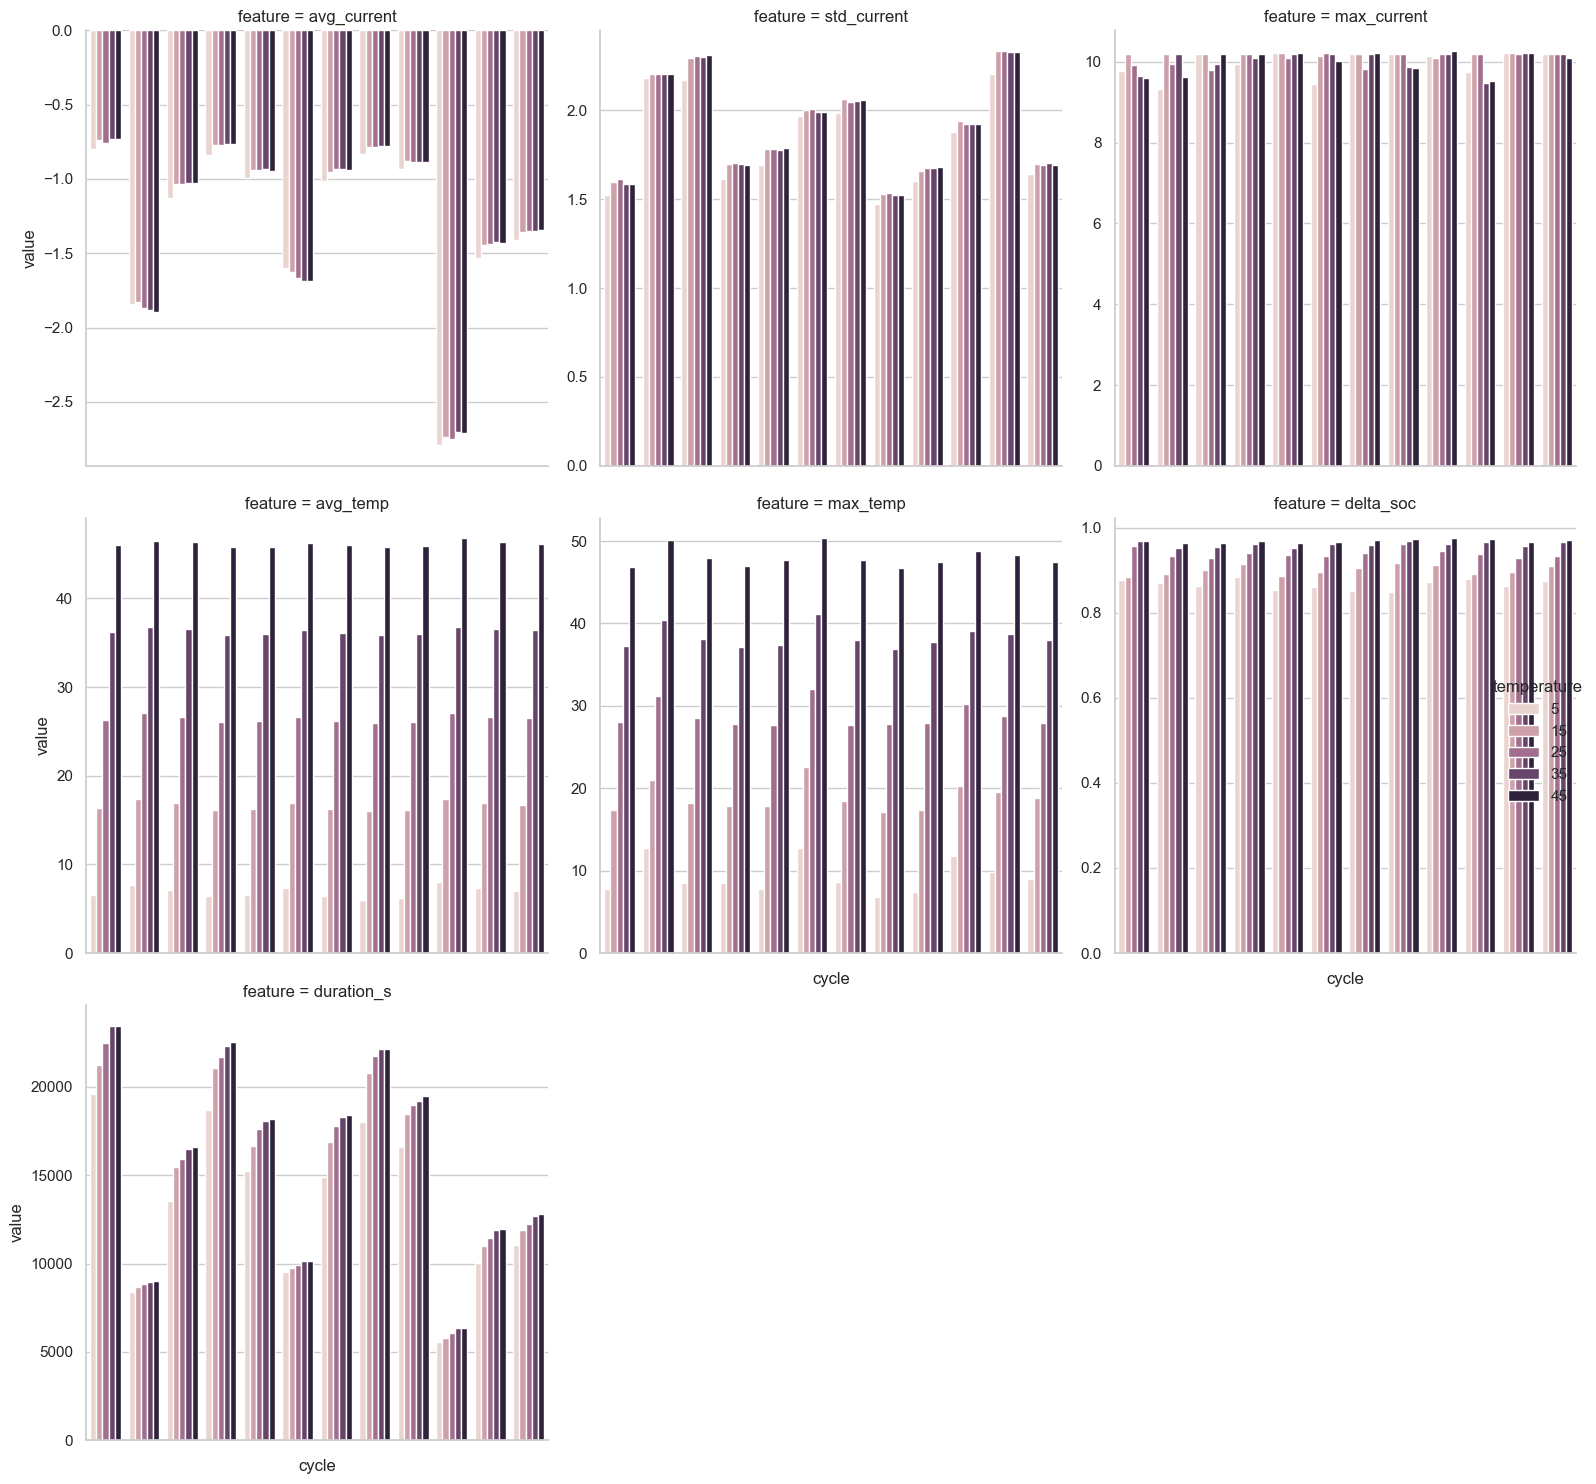

In [99]:
if __name__ == "__main__":
    feature_df = extract_all_features(data)
    print("\nExtracted feature sample:\n", feature_df.head())
    visualize_stress_features(feature_df)
